<h1> Density Prediction </h1>

In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns

from collections import Counter

from matplotlib import pyplot

from sklearn import metrics
from sklearn import preprocessing
from sklearn import utils
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, learning_curve, cross_validate, cross_val_score, StratifiedShuffleSplit, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

title_font = {'fontname':'Times New Roman', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}
axis_font = {'fontname':'Times New Roman', 'size':'12'}

<h2> Reading Data </h2>

In [2]:
density_df = pd.read_csv('DensityData.csv')
display(density_df.head())

,IBP,MW,T,P,Density
0,192.4,539.2,190.0,2.01,907.6
1,192.4,539.2,174.6,2.01,917.3
2,192.4,539.2,150.3,2.02,932.7
3,192.4,539.2,125.0,1.99,947.9
4,192.4,539.2,100.6,2.02,962.6


In [3]:
input_cols = ['T', 'P']
X = density_df[input_cols]
y = density_df.Density
print(f"Size of featuers:{X.shape}\nSize of targets:{y.shape}")

X.columns
X.describe()

Size of featuers:(189, 2)
Size of targets:(189,)


,T,P
count,189.000000,189.000000
mean,105.955026,6.766243
std,42.777633,4.176181
min,23.000000,0.920000
25%,70.000000,3.410000
50%,100.600000,6.870000
75%,140.000000,10.310000
max,190.000000,13.880000


### Plotting the data

C:\Users\mo_co\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


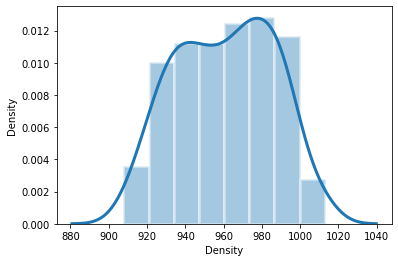

In [4]:
a = sns.distplot(density_df["Density"], hist=True, hist_kws={"edgecolor": 'w', "linewidth": 3}, kde_kws={"linewidth": 3})

The above plot is a distrubtion for the density data. This plot shows that the majority of the density data used in this code is between 920 and 1000 (Kg/m^3). 

### Outlier detection

In [5]:
# Tukey method (Tukey JW., 1977) used to detect the outliers

def detect_outliers(df: pd.DataFrame, min_outliers, features):
   
    outlier_indices = []
    
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
     
        outlier_indices.extend(outlier_list_col)

        
    # select row containing any outliers  
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > min_outliers)
    
    return multiple_outliers

In [6]:
#outliers detected based on T and P numerical values 
outliers_to_drop = detect_outliers(density_df, 0, ["T","P"])
density_df.loc[outliers_to_drop] 

,IBP,MW,T,P,Density


No outlier has been detected on the dataset. 

## Model Training 
### Importing the regressors

In [7]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [8]:
random_state = 2
regressors = []
regressors.append(SVR())
regressors.append(AdaBoostRegressor(DecisionTreeRegressor(random_state=random_state),random_state=random_state, learning_rate=0.1))
regressors.append(RandomForestRegressor(random_state=random_state))
regressors.append(ExtraTreesRegressor(random_state=random_state))
regressors.append(LinearRegression())

### Splitting the Dataset

In [9]:
# Splitting the dataset into 85% of training data and 15% testing data 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85)
print(f"Size of X_train:{X_train.shape}\nSize of X_test:{X_test.shape}")
print(f"Size of y_train:{y_train.shape}\nSize of y_test:{y_test.shape}")

Size of X_train:(160, 2)
Size of X_test:(29, 2)
Size of y_train:(160,)
Size of y_test:(29,)


In [10]:
# Fitting Polynomial regression (degree 2) to the dataset 
poly_reg = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly_reg.fit_transform(X_train)
X_poly_test= poly_reg.transform(X_test)
X_poly= poly_reg.transform(X)

The new input is created for polynomial regression to generate all polynomial combination of features equivalent to the degree of the polynomial specified. The new input is created based on X_train to fit the degree 2 polynomial.  

### Cross Validation 

Cross validation is performed to estimate the performance of the algorithms on unseen dataset. It gives an idea about how each model will perform on test dataset. It is also performed to observe how accurate a model will predict. 

In [11]:
# Cross validate model with Kfold repeated cross validation
kfold = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state=1)

# R2 scoring for cross validation 
r2_means = []
r2_std = []
r2_values = []

# MSE scoring for cross Validation 
nmse_means = []
nmse_std = []
nmse_values = []

for regressor in regressors:
    print(regressor.__class__.__name__)
    regressor_name = regressor.__class__.__name__
    
    x = X_poly_train if regressor_name == 'LinearRegression' else X_train

    r2_result = cross_val_score(regressor, x, y_train, scoring = 'r2', cv = kfold, n_jobs=4)
    nmse_result = cross_val_score(regressor, x, y_train, scoring = 'neg_mean_squared_error', cv = kfold, n_jobs=4)
    
    r2_means.append(r2_result.mean())
    r2_std.append(r2_result.std())
    r2_values.append(r2_result)


    nmse_means.append((-1)*nmse_result.mean())
    nmse_std.append(nmse_result.std())
    nmse_values.append(nmse_result)
    

cv_res_R2 = pd.DataFrame({
    "CrossValMeansR2": r2_means,
    "CrossValerrorsR2": r2_std,
    "RawCrossValResutlsR2": r2_values,
    "Algorithm": [regressor.__class__.__name__ for regressor in regressors]
})

cv_res_NMSE = pd.DataFrame({
    "CrossValMeansNMSE": nmse_means,
    "CrossValerrorsNMSE": nmse_std,
    "RawCrossValResutlsNMSE": nmse_values,
    "Algorithm": [regressor.__class__.__name__ for regressor in regressors]
})
display(cv_res_R2)
display(cv_res_NMSE)


SVR
AdaBoostRegressor
RandomForestRegressor
ExtraTreesRegressor
LinearRegression


,CrossValMeansR2,CrossValerrorsR2,RawCrossValResutlsR2,Algorithm
0,0.903113,0.026126,"[0.9245609361314786, 0.8901865653990428, 0.853...",SVR
1,0.983741,0.006068,"[0.9901538328048347, 0.9819479296422047, 0.988...",AdaBoostRegressor
2,0.989491,0.003345,"[0.9909924264851006, 0.986717364819211, 0.9919...",RandomForestRegressor
3,0.985220,0.005575,"[0.9904202743036112, 0.9840153652576866, 0.991...",ExtraTreesRegressor
4,0.993012,0.002988,"[0.9948837451444744, 0.9906458889904894, 0.994...",LinearRegression


,CrossValMeansNMSE,CrossValerrorsNMSE,RawCrossValResutlsNMSE,Algorithm
0,61.916093,27.647564,"[-45.64499201449691, -44.94306555595996, -95.4...",SVR
1,9.391917,2.751002,"[-5.957500000000086, -7.388124999999977, -7.77...",AdaBoostRegressor
2,6.084503,1.455996,"[-5.450102374999686, -5.43615037500064, -5.236...",RandomForestRegressor
3,8.488672,2.546835,"[-5.796287499999021, -6.541990874999925, -5.81...",ExtraTreesRegressor
4,3.929422,0.882889,"[-3.0956297712231162, -3.828333262189911, -3.6...",LinearRegression


In [12]:
cv_res_R2.sort_values(by='CrossValMeansR2', ascending=False, inplace=True)
cv_res_NMSE.sort_values(by='CrossValMeansNMSE', ascending=True, inplace=True)

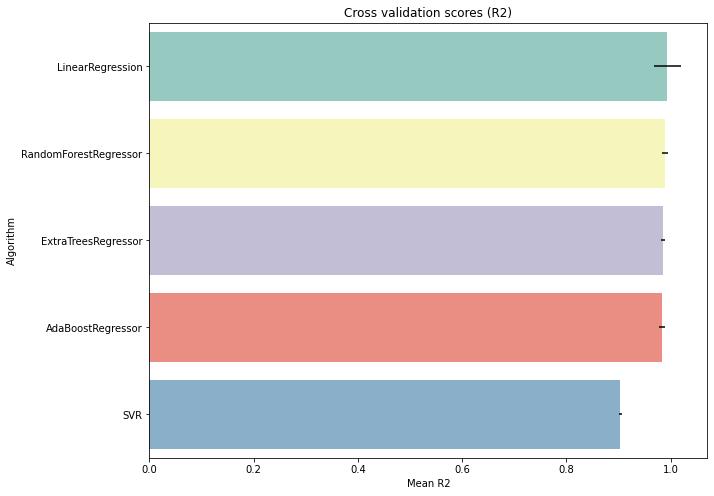

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
g = sns.barplot(x = cv_res_R2.CrossValMeansR2, y = cv_res_R2.Algorithm, data=cv_res_R2, palette="Set3", orient = "h", ax=ax, **{'xerr':r2_std})
g.set_xlabel("Mean R2")
g = g.set_title("Cross validation scores (R2)")

The above plot is the average R2 cross validation score for each model. It can be observed that the average R2 score for Linear Regression/Polynomial Regression is the highest. The higher the R2 cross validation score, the better the model will perform predictions. The above barplot concludes that Polynomial regression might perform really well as compared to other algorithms. 

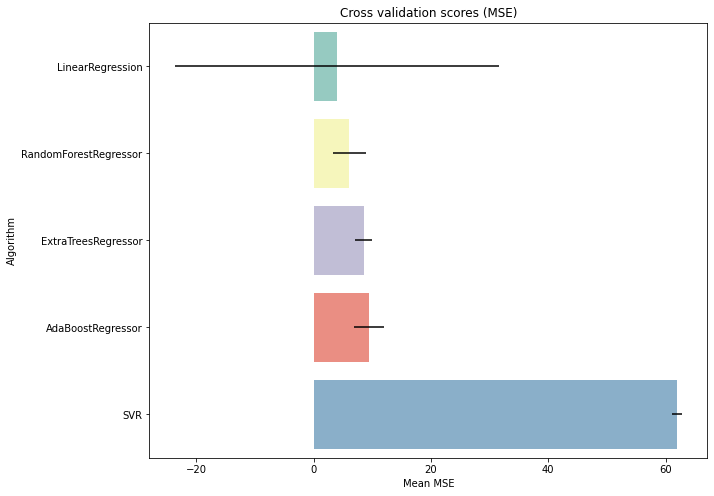

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
g = sns.barplot(x = cv_res_NMSE.CrossValMeansNMSE, y = cv_res_NMSE.Algorithm, data=cv_res_NMSE, palette="Set3", orient = "h", ax=ax, **{'xerr':nmse_std})
g.set_xlabel("Mean MSE")
g = g.set_title("Cross validation scores (MSE)")

The above plot is the average MSE cross validation score for each model. It can be observed that the average MSE score for Linear Regression/Polynomial Regression is the lowest. The lower the MSE cross validation score, the better the model will perform predictions. The above barplot concludes that Polynomial regression might perform really well as compared to other algorithms. 

In [15]:
# The code below shows all the models used for the study such as LinearRegression (Polynomial Regression),
# Random Forest, SVR, AdaBoost and Extra Trees. All the models are provided with multiple parameter distributions
# according to the model requirement to find out best performing parameters for each model based on 
# training and testing scores calculated for each parameter set.
models = [
    {
        'model': LinearRegression(),
        'param_distributions': {},
        'is_tree': False
    },
    {
        'model': RandomForestRegressor(),
        'param_distributions': {
            "max_depth": [None],
            "max_features": [1, 3, 10],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "n_estimators" :[10, 50, 100, 300],
            "bootstrap": [False]
            
        },
        'is_tree': True
    },
    {
        'model': SVR(), 
        'param_distributions': {
            'kernel': ['rbf'], 
            'gamma': [0.001, 0.01, 0.1, 1],
            'C': [1, 10, 50, 100, 200, 300, 1000]
        },
        'is_tree': False
    },
    {
        'model': AdaBoostRegressor(random_state=random_state),
        'param_distributions': {
            "n_estimators": [1, 2],
            "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]
        },
        'is_tree': True
    },
    {
        'model': ExtraTreesRegressor(),
        'param_distributions': {
            "max_depth": [None],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "bootstrap": [False],
            "n_estimators" :[100,300],
        },
        'is_tree': True
    }
]

for model in models:
    model['train_score'] = None
    model['test_score'] = None

In [16]:
# Finding the best model based on the best parameters
best_model = None
best_model_test_score = 0

for model_set in models:
    model = model_set['model']
    print('\n', model.__class__.__name__)
    model_name = model.__class__.__name__
    param_distributions = model_set['param_distributions']
    gs = GridSearchCV(
        model, param_distributions, scoring='r2', cv=10, return_train_score=True, n_jobs=-1, verbose=2)
    if model_name == 'LinearRegression':
        gs.fit(X_poly_train, y_train)
    else:
        gs.fit(X_train, y_train)
   

    cvres = gs.cv_results_
    for mean_train_score, std_train_score, mean_test_score, std_test_score, params in zip(cvres['mean_train_score'], cvres['std_train_score'], cvres['mean_test_score'], cvres['std_test_score'], cvres['params']):
        print(f'{mean_train_score:.4f}, {std_train_score:.4f} | {mean_test_score:.4f}, {std_test_score:.4f}', "-for->", params)

    model = gs.best_estimator_
    train_score = gs.best_score_
    if model_name == 'LinearRegression':
        test_score = model.score(X=X_poly_test, y=y_test)
    else:
        test_score = model.score(X=X_test, y=y_test)
            
    print('----------------\nbest params:', gs.best_params_)
    print(f'Scores: training={train_score:.4f}, testing={test_score:.4f}')

    model_set['model'] = model
    model_set['train_score'] = train_score
    model_set['test_score'] = test_score


 LinearRegression
Fitting 10 folds for each of 1 candidates, totalling 10 fits
0.9944, 0.0003 | 0.9928, 0.0039 -for-> {}
----------------
best params: {}
Scores: training=0.9928, testing=0.9963

 RandomForestRegressor
Fitting 10 folds for each of 108 candidates, totalling 1080 fits


C:\Users\mo_co\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
720 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mo_co\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mo_co\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py", line 442, in fit
    trees = Parallel(
  File "C:\Users\mo_co\AppData\Roaming\Python\Python39\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatc

1.0000, 0.0000 | 0.9672, 0.0196 -for-> {'bootstrap': False, 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
1.0000, 0.0000 | 0.9761, 0.0091 -for-> {'bootstrap': False, 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
1.0000, 0.0000 | 0.9765, 0.0083 -for-> {'bootstrap': False, 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
1.0000, 0.0000 | 0.9775, 0.0085 -for-> {'bootstrap': False, 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
0.9983, 0.0003 | 0.9656, 0.0135 -for-> {'bootstrap': False, 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 10}
0.9986, 0.0004 | 0.9689, 0.0144 -for-> {'bootstrap': False, 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 50}
0.9987, 

### Plot Learning Curves

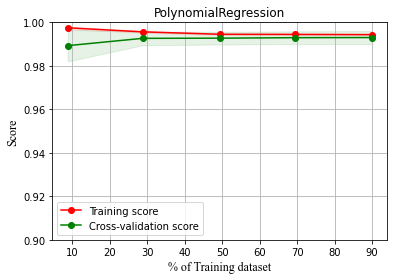

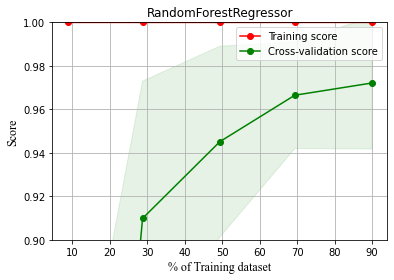

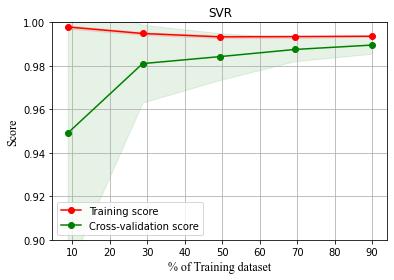

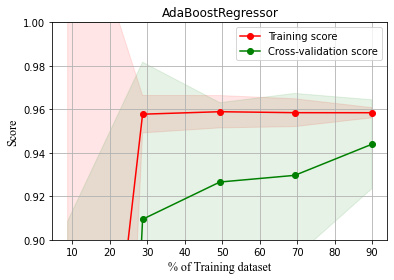

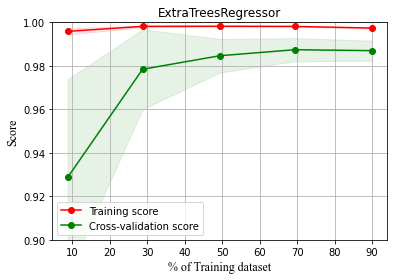

In [17]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(0.1, 1, 5)):
    """
    Generate a simple plot of the training and validation learning curve
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("% of Training dataset",**axis_font)
    plt.ylabel("Score",**axis_font)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    train_size_percentage = train_sizes/160*100
    
    plt.grid()
    plt.fill_between(train_size_percentage, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_size_percentage, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_size_percentage, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_size_percentage, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

for model_set in models:
    model = model_set['model']
    model_name = model.__class__.__name__
   
   
    if model_name == 'LinearRegression':
        model_name = 'PolynomialRegression'
        g = plot_learning_curve(model, model_name, X_poly_train, y_train, ylim=[0.9, 1], cv=kfold)
    else:
        g = plot_learning_curve(model, model_name, X_train, y_train, ylim=[0.9, 1], cv=kfold)

The learning curves plotted above for each model are representation of R2 scores for training and cross validation as the % of training dataset is increased. The polynomial regression model learning curves shows that as the % of training dataset is increased the training and cross validation R2 scores are similar, which shows that the model is performing well. As seen for the other models, the training learning curve scores does not match the validation learning curve. Hence, just by observing the curves, Polynomial Regression model shows good performance.  

### Permutation Feature Importance

PolynomialRegression
[('T', 1669.2684914828108), ('P', 14.783940207745578), ('T^2', 18.71515112630361), ('TP', 6.011003092470284), ('P^2', 3.464011411837126)]


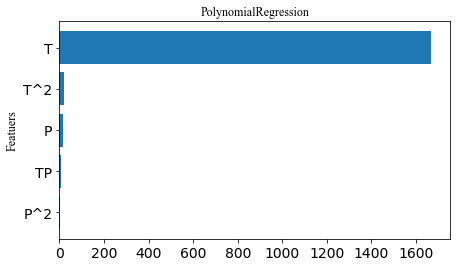

RandomForestRegressor
[('T', 1164.0757831452806), ('P', 34.40757447374989)]


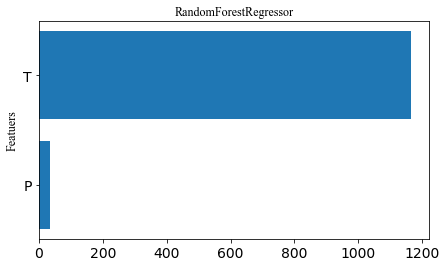

SVR
[('T', 1278.4766001704702), ('P', 15.769434225953187)]


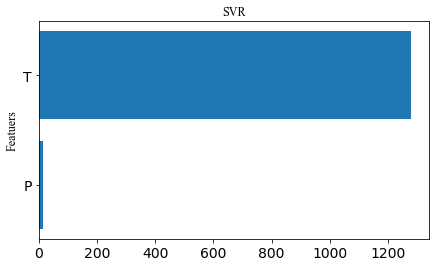

AdaBoostRegressor
[('T', 1153.7816255844123), ('P', 0.0)]


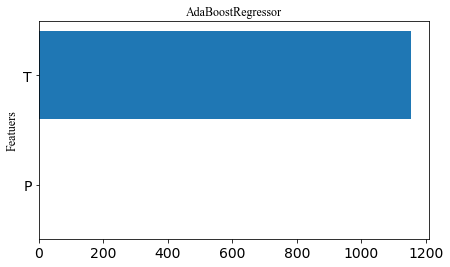

ExtraTreesRegressor
[('T', 1259.2467727507621), ('P', 16.970802401111882)]


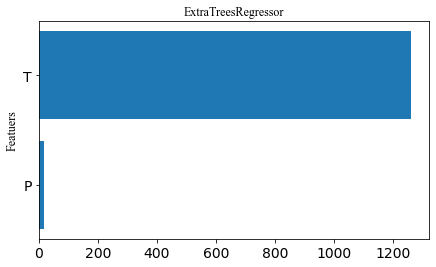

In [18]:
# Finding the importance of each feature based on the models 
def permu_important(estimator, title, X, y):
 
     print(title)
     results = permutation_importance(model, X, y, scoring='neg_mean_squared_error')
     importance = results.importances_mean
     print(list(zip(input_cols, importance)))
     feature_importances_sorted = sorted(importance)
     y_ticks_names = [x for _,x in sorted(zip(importance, input_cols))]
     y_ticks = range(1,len(importance) + 1)

     plt.rcParams['figure.figsize'] = [7, 4]
     
     fig, ax = plt.subplots()
     ax.barh(y_ticks, feature_importances_sorted)
     plt.yticks(y_ticks, y_ticks_names)
     ax.set_ylabel('Featuers', **axis_font)
     ax.set_title('Feature Importance', **title_font)
     plt.title(title)
     plt.xticks(fontsize=14)
     plt.yticks(fontsize=14)
     plt.show()

    
            
for model_set in models:
    model = model_set['model']
    model_name = model.__class__.__name__
    if model_name == 'LinearRegression':
        model_name = 'PolynomialRegression'
        input_cols = ['T', 'P','T^2','TP','P^2']
        r= permu_important(model, model_name, X_poly_train, y_train)
    else:
        input_cols = ['T', 'P']
        r= permu_important(model, model_name, X_train, y_train)

Based on all the permutation feature results for all the models, it can be observed that the negative mean square error increases drastically for all the models as the feature T is permutated. Hence, it can be concluded that temperature (T) is the most important feature for each model. 

### Measured Vs. Predicted Density and MSE and R2 scores for training and testing data

PolynomialRegression

Final Model Results
-----------------
train: mse= 1.90, r2= 0.994344
test : mse= 1.61, r2= 0.996256
all  : mse= 1.86, r2= 0.994658


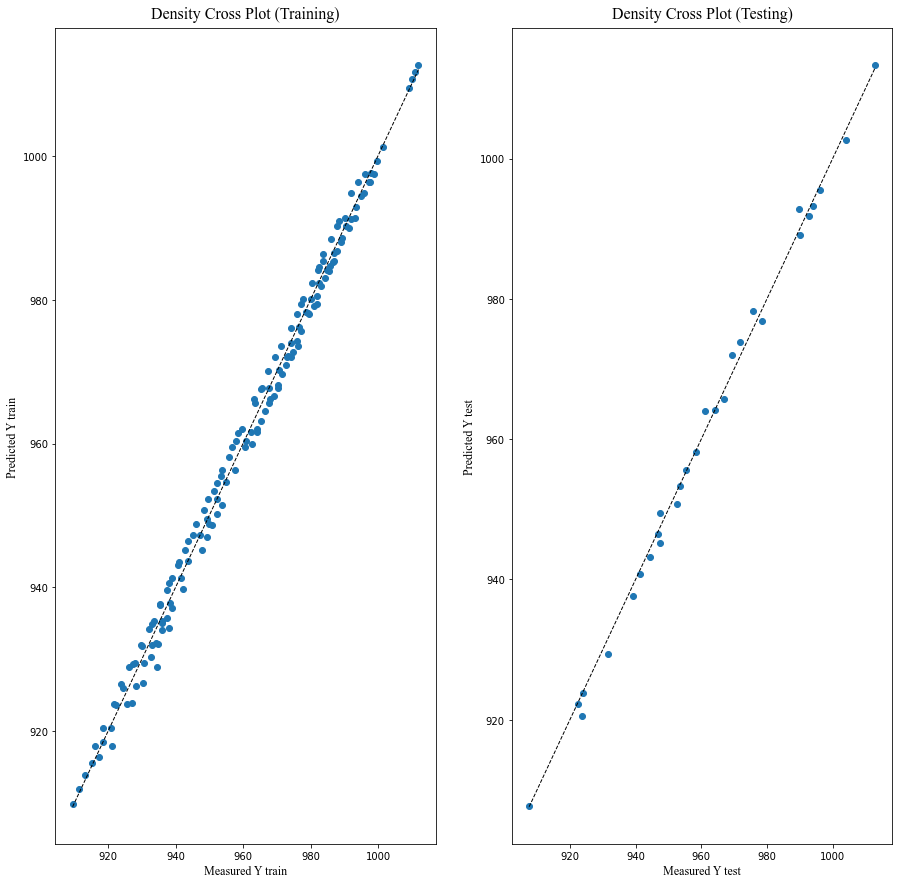

RandomForestRegressor

Final Model Results
-----------------
train: mse= 0.02, r2= 1.000000
test : mse= 3.21, r2= 0.985143
all  : mse= 1.26, r2= 0.997558


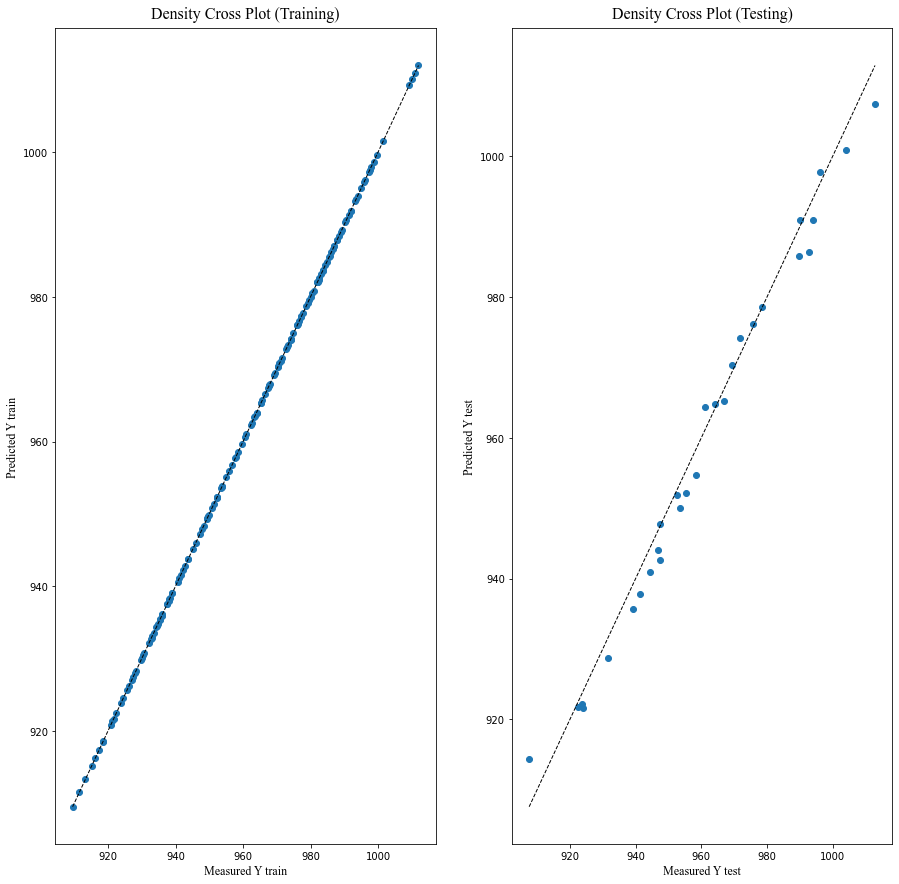

SVR

Final Model Results
-----------------
train: mse= 2.00, r2= 0.993732
test : mse= 2.32, r2= 0.992236
all  : mse= 2.06, r2= 0.993487


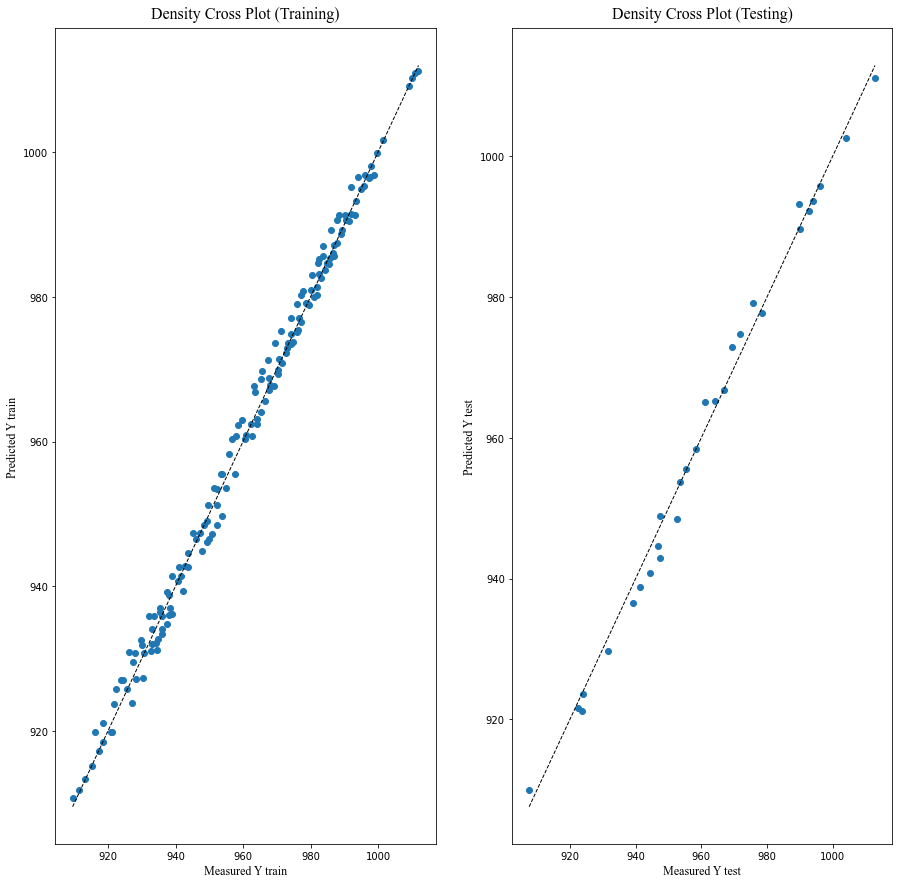

AdaBoostRegressor

Final Model Results
-----------------
train: mse= 5.21, r2= 0.957584
test : mse= 7.33, r2= 0.922690
all  : mse= 5.59, r2= 0.951851


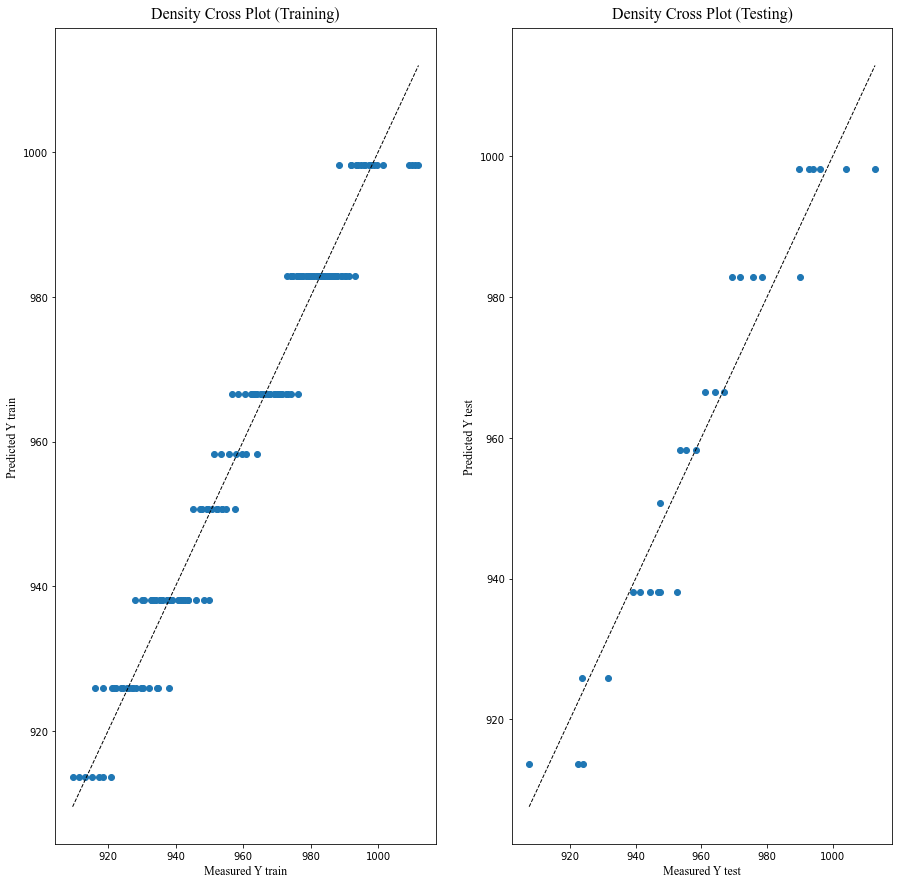

ExtraTreesRegressor

Final Model Results
-----------------
train: mse= 1.35, r2= 0.997141
test : mse= 2.71, r2= 0.989436
all  : mse= 1.64, r2= 0.995875


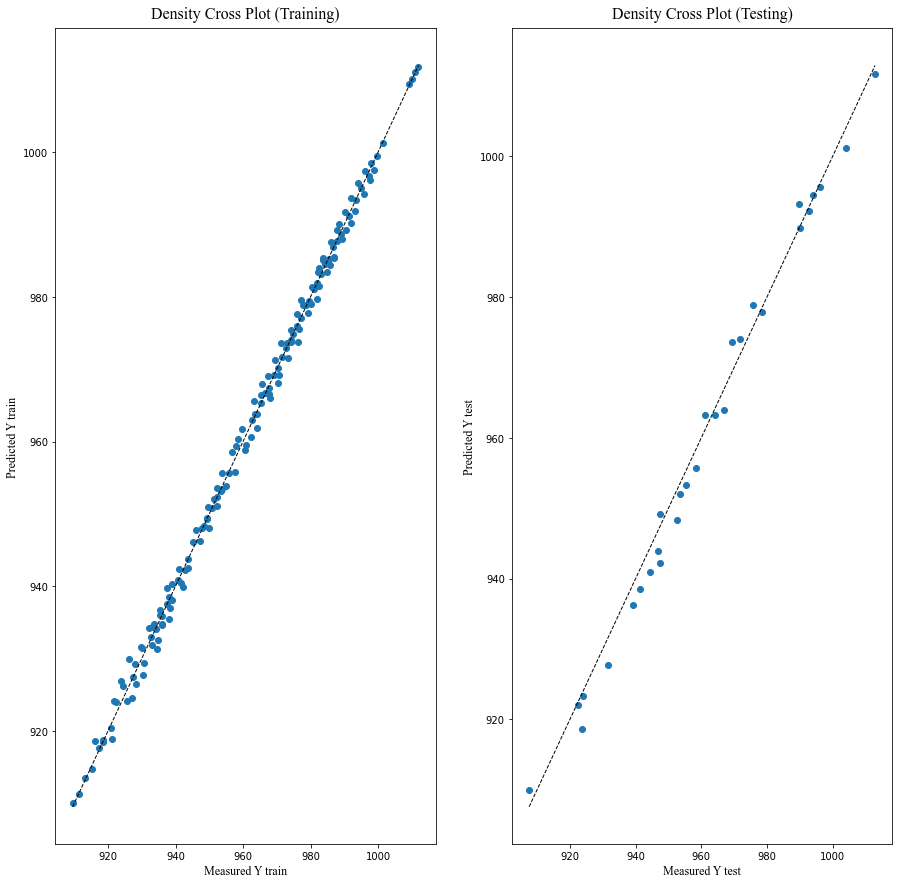

In [19]:
# Prediction of Density values based on each model followed by a plot between measured and predicted density values.
# MSE and R2 scores also calculated based on measured and predicted values for training and testing dataset.
for model_set in models:
    model = model_set['model']
    model_name = model.__class__.__name__
    
    if model_name == 'LinearRegression':
        model_name = 'PolynomialRegression'
        y_pred       = model.predict(X_poly)
        y_train_pred = model.predict(X_poly_train)
        y_test_pred  = model.predict(X_poly_test)
       
    else: 
        y_pred       = model.predict(X)
        y_train_pred = model.predict(X_train)
        y_test_pred  = model.predict(X_test)

    print(model_name)
    mse_train = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    r2_train = metrics.r2_score(y_train, y_train_pred)

    mse_test = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
    r2_test = metrics.r2_score(y_test, y_test_pred)
    
    mse = np.sqrt(metrics.mean_squared_error(y, y_pred))
    r2 = metrics.r2_score(y, y_pred)
    print('\nFinal Model Results\n-----------------')
    print('train: mse= {0:.2f}, r2= {1:02f}'.format(mse_train, r2_train))
    print('test : mse= {0:.2f}, r2= {1:02f}'.format(mse_test, r2_test))
    print('all  : mse= {0:.2f}, r2= {1:02f}'.format(mse, r2))

    plt.rcParams['figure.figsize'] = [15, 15]
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.scatter(y_train, y_train_pred)
    ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
    ax1.set_xlabel('Measured Y train', **axis_font)
    ax1.set_ylabel('Predicted Y train', **axis_font)
    ax1.set_title('Density Cross Plot (Training)', **title_font)
    ax2.scatter(y_test, y_test_pred)
    ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    ax2.set_xlabel('Measured Y test', **axis_font)
    ax2.set_ylabel('Predicted Y test', **axis_font)
    ax2.set_title('Density Cross Plot (Testing)', **title_font)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

The above plots are representation of measured vs. predicted density values for all the five models for training and testing data. As observed in the plots above, the mse and r2 values for the polynomial regression model for both training and testing data are very similar. For other models the mse and r2 values are different and models are not performing well while predicting densities. Hence based on the measured vs. predicted plots for training and testing data, it can be concluded that polynomial regression can be the best performing model. 

After analyzing all the results above, which includes cross validation, learning curves, permutation feature importance and predicted and measured density values, it can be concluded that polynomial regression is the best performing model as compared to all the other models. Since Polynomial Regression is selected as best performing model, only its being used to perform furture analysis such as to plot Heatmap of relative percentage error, to plot contour map based on predicted density values and to extract density equation. 

### Heatmap of Relative Percent Error

PolynomialRegression


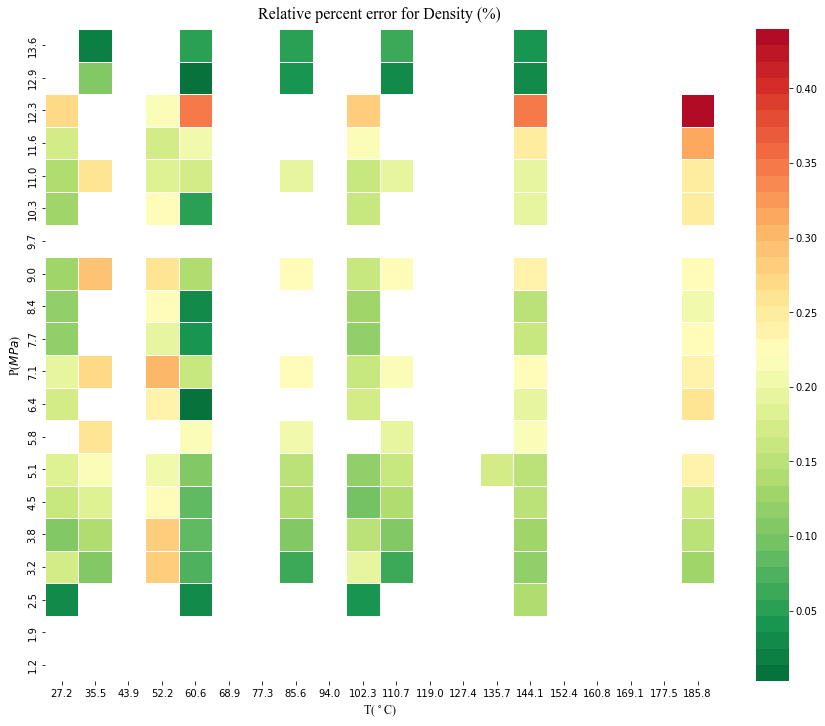

In [20]:
# Heatmap of Relative precent error for Density based on Polynomial regression 
for model_set in models:
    model = model_set['model']
    model_name = model.__class__.__name__
    
    if model_name == 'LinearRegression':
        model_name = 'PolynomialRegression'
        df2 = density_df
        df2['Density_pred'] = model.predict(X_poly)
        df2['Density_err'] = np.abs(df2['Density'] - df2['Density_pred'])

    # create the heatmap
        print(model_name)
        min_points_per_grid = 1
        divs = 20
        T_bins = np.linspace(min(df2['T']), max(df2['T']), divs + 1)
        P_bins = np.linspace(min(df2['P']), max(df2['P']), divs + 1)
        T_ticks_heatmap = np.round([(T_bins[i-1] + T_bins[i])/2 for i in range(1, len(T_bins))], 1)    
        P_ticks_heatmap = np.round([(P_bins[i-1] + P_bins[i])/2 for i in range(1, len(P_bins))], 1)

        df_heatmap = df2[['T', 'P', 'Density', 'Density_err']].groupby(
        [pd.cut(df2['T'], bins=T_bins),pd.cut(df2['P'], bins=P_bins)]).aggregate(lambda x: tuple(x))

        for i in df_heatmap.index:
            if df_heatmap.loc[i, 'T'] is np.nan or None:
                df_heatmap.loc[i, 'Density_err_median'] = np.nan
            else:
                if len(tuple(df_heatmap.loc[i, 'Density_err'])) >= min_points_per_grid:
                    df_heatmap.loc[i, 'Density_err_median'] = np.median(df_heatmap.loc[i, 'Density_err']) / np.median(df_heatmap.loc[i, 'Density']) * 100
                else:
                    df_heatmap.loc[i, 'Density_err_median'] = np.nan

        fig, ax2 = plt.subplots(figsize=(15,12))
        pal = sns.color_palette("RdYlGn_r", 40)    
        ax2 = sns.heatmap(data=np.array(df_heatmap['Density_err_median'].to_numpy()).reshape((divs, divs)),
                  xticklabels=T_ticks_heatmap, yticklabels=P_ticks_heatmap,
                  linewidths=1,
                  cmap=pal)
        ax2.invert_yaxis()
        ax2.set_xlabel(r"T($^\circ$C)", **axis_font)
        ax2.set_ylabel("P($MPa$)", **axis_font)
        ax2.set_title("Relative percent error for Density (%)", **title_font)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

        cax = plt.gcf().axes[-1]
        cax.tick_params(labelsize=10)

        plt.show()

In [21]:
# 400 T and P pairs generated to predict Density 
T = []
P = []
df2 = density_df
divs = 20
T_bins = np.linspace(min(df2['T']), max(df2['T']), divs + 1)
P_bins = np.linspace(min(df2['P']), max(df2['P']), divs + 1)
T_ticks_heatmap = np.round([(T_bins[i-1] + T_bins[i])/2 for i in range(1, len(T_bins))], 1)    
P_ticks_heatmap = np.round([(P_bins[i-1] + P_bins[i])/2 for i in range(1, len(P_bins))], 1)

for i in range(len(T_ticks_heatmap)) :
    for j in range(len(P_ticks_heatmap)) :
        T.append(T_ticks_heatmap[i])
        P.append(P_ticks_heatmap[j])    

## Contour Plot 

In [22]:
T_P = np.column_stack((T, P))
T_P
T_Pdataframe = pd.DataFrame(T_P, columns=['T', 'P'])
T_P_poly= poly_reg.transform(T_Pdataframe)

for model_set in models:
    model = model_set['model']
    model_name = model.__class__.__name__
# Densities predicted using 400 T and P pairs using polynomial regression and then a contour plot is formed     
    if model_name == 'LinearRegression':
        #print(model_name)
        y_pred_log = model.predict(T_P_poly)
   
        fig = go.Figure(data =
        go.Contour(
            z = y_pred_log,
            x= T, 
            y= P))
        fig.update_layout(xaxis_title=('T(C)'), yaxis_title=("P(MPa)"), legend_title="Density")
        fig.show()

## Extraction of Density Equation

In [23]:
# Coefficients and Intercepts extracted from the model to form an equation 
for model_set in models:
    model = model_set['model']
    model_name = model.__class__.__name__
    if model_name == 'LinearRegression':
        coef = []
        coef = model.coef_
        intercept = model.intercept_
        #print (coef)
        #print (intercept)
        print (f"Density = {coef[0]}*T +  {coef[1]}*P + {coef[2]}*T^2 + {coef[3]}*T*P {coef[4]}*P^2 + {intercept}")

Density = -0.6851016722979796*T +  0.6485469240356023*P + 0.0003265294404838359*T^2 + 0.003082979368124062*T*P -0.020673950790753435*P^2 + 1023.7214032532291


In [24]:
# Densities predicted based on the equation 
y_eq_pred = []
for i in range(len(T_ticks_heatmap)) :
    for j in range(len(P_ticks_heatmap)) :
        y_equ = coef[0]* T_ticks_heatmap[i] +  coef[1] *P_ticks_heatmap[j]  + coef[2] *T_ticks_heatmap[i]**2 + coef[3] *T_ticks_heatmap[i]*P_ticks_heatmap[j] + coef[4] *P_ticks_heatmap[j]**2 + intercept
        y_eq_pred.append(y_equ)

## Contour Plot based on the Equation

This is the contour plot created based on the density values calculated using the equation extracted to test the equation performance as compared to the model. 

In [25]:
fig = go.Figure(data =
    go.Contour(
        z = y_eq_pred,
        x= T, 
        y= P
))
fig.update_layout(title="Density contour map", xaxis_title=('T(C)'), yaxis_title=("P(MPa)"), legend_title="Density")
fig.show()